[View in Colaboratory](https://colab.research.google.com/github/shaabhishek/arm_sourcecode/blob/master/CartPole_REINFORCE.ipynb)

In [1]:
# !pip install gym
import gym
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
import numpy as np
import random
import tensorflow as tf
tf.enable_eager_execution()

seed_val = 111
np.random.seed(seed_val)
random.seed(seed_val+1)
tf.set_random_seed(seed_val+2)
env.seed(seed_val+3)

[114]

In [3]:
from collections import deque
from keras.models import clone_model
# from keras.utils import to_categorical
from keras import optimizers

Using TensorFlow backend.


In [0]:
def preprocess(img):
    return np.reshape(img, (1,4))


In [0]:
N_ACTIONS = env.action_space.n
DIM_STATES = env.observation_space.shape[0]
N_EPISODES = 100
BATCH_SIZE = 200
SGD_BATCH_SIZE = 16
TIMESTEP_LIMIT = env.spec.timestep_limit
discount_factor = 0.99

In [0]:
class PolicyEstimator():
  """
  Policy Function Approximation
  """
  def __init__(self, learning_rate = 0.1):
    self.learning_rate = learning_rate
    self.pi = self._build_model()
    self.grad_init = [tf.zeros_like(theta) for theta in self.pi.get_weights()]
  
  def _build_model(self):
    model = tf.keras.Sequential([
#         tf.keras.layers.Dense(16, input_shape=(4,), activation='relu'),
#         tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(N_ACTIONS, input_shape=(4,), activation='linear', use_bias=True)
    ])
    self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate)
    return model
  
  def select_action(self, state):
    return tf.squeeze(tf.multinomial(pi_model.pi(state), 1)).numpy()
  
  def loss(self, state, action, advantage):
    # negative loss because we're maximizing
    ## picking the log_probability corresponding to the action taken and
    ## scaling it by 'advantage'
    pi = tf.nn.softmax(self.pi(state))
    return -tf.gather(tf.squeeze(tf.log(pi)), action)*advantage
  
  def compute_gradient(self, state, action, advantage):
    """
    Compute the gradient at time t
    :param state: the state for which pi will be calculated, shape 1 x |S|
    :param action: action taken. 
    :return list of Gradient tensors with length = count(weights)+ count(biases)
    """
    with tf.GradientTape() as tape:
      loss_val = self.loss(state, action, advantage)
    return tape.gradient(loss_val, self.pi.variables)
  
  def apply_gradient(self, grads):
    """"""
    self.optimizer.apply_gradients(zip(grads, self.pi.variables),
                                   global_step=tf.train.get_or_create_global_step())


pi_model = PolicyEstimator()

In [36]:
pi_model = PolicyEstimator()
avg_rewards = []
for episode in range(1,N_EPISODES+1):
  
  episode_rewards = []
  # copy zero initialized list by value
  grad = pi_model.grad_init[:]
  all_returns = np.zeros((BATCH_SIZE, TIMESTEP_LIMIT))
  rewards = [[] for _ in range(BATCH_SIZE)]
  states = [[] for _ in range(BATCH_SIZE)]
  actions = [[] for _ in range(BATCH_SIZE)]
  
  for roll_i in range(BATCH_SIZE):
    done = False
    cur_state = preprocess(env.reset())
    for t in range(TIMESTEP_LIMIT):
      action = pi_model.select_action(cur_state)
      next_state, reward, done, info = env.step(action)
      next_state = preprocess(next_state)
      states[roll_i].append(cur_state)
      actions[roll_i].append(action)
      rewards[roll_i].append(reward)
      cur_state = next_state
      if done:
        episode_rewards.append(np.sum(rewards[roll_i]))
        for t_ in range(len(rewards[roll_i])):
          all_returns[roll_i,t_] = sum([discount_factor**ix * reward for ix, reward in enumerate(rewards[roll_i][t_:])])
        break
      
  baselines = np.mean(all_returns, axis=0)
  advantages = all_returns - baselines
    
    ## random sampling rollouts for gradient update will lead to a SGD step
    ## Here, SGD_BATCH_SIZE = BATCH_SIZE will give vanilla Gradient Descent
    ## running the gradient update for all rollouts will be expensive (=vanilla GD)
  for roll_i in random.sample(range(BATCH_SIZE), SGD_BATCH_SIZE):
#   for roll_i in range(BATCH_SIZE):
    for t in range(len(states[roll_i])):
#       pi_model.optimizer.minimize(loss=lambda: pi_model.loss(states[roll_i][t], actions[roll_i][t], advantages[roll_i,t]),
#                                   global_step=tf.train.get_or_create_global_step())
      grad_t = pi_model.compute_gradient(states[roll_i][t], actions[roll_i][t], advantages[roll_i][t])
      # grad_t is a list of weights and biases, so do element-wise summation
      grad = [grad[i] + grad_t[i] for i in range(len(grad))]
  
  ## Mean of gradient
  grad = [g_i/SGD_BATCH_SIZE for g_i in grad]

  ## Normalize the gradient
  grad = [g_i/(np.linalg.norm(g_i)+1e-8) for g_i in grad]
  pi_model.apply_gradient(grad)  
  
  avg_rewards.append(np.mean(episode_rewards))
  if episode%1 == 0: print("Episode:{}, Avg Rewards:{}, Norm of Weights:{}".format(episode,
                                                                                   avg_rewards[-1],
                                                                                   np.linalg.norm(pi_model.pi.get_weights()[0])))

Episode:1, Avg Rewards:12.995, Norm of Weights:1.4958665370941162
Episode:2, Avg Rewards:12.89, Norm of Weights:1.4455697536468506
Episode:3, Avg Rewards:13.26, Norm of Weights:1.3990845680236816
Episode:4, Avg Rewards:14.05, Norm of Weights:1.3593716621398926
Episode:5, Avg Rewards:15.635, Norm of Weights:1.324618935585022
Episode:6, Avg Rewards:16.515, Norm of Weights:1.2981139421463013
Episode:7, Avg Rewards:16.905, Norm of Weights:1.2786214351654053
Episode:8, Avg Rewards:19.28, Norm of Weights:1.2649801969528198
Episode:9, Avg Rewards:19.23, Norm of Weights:1.2614216804504395
Episode:10, Avg Rewards:21.765, Norm of Weights:1.265426754951477
Episode:11, Avg Rewards:23.78, Norm of Weights:1.2803051471710205
Episode:12, Avg Rewards:25.125, Norm of Weights:1.2976747751235962
Episode:13, Avg Rewards:29.26, Norm of Weights:1.3208777904510498
Episode:14, Avg Rewards:30.08, Norm of Weights:1.3542221784591675
Episode:15, Avg Rewards:31.985, Norm of Weights:1.3777638673782349
Episode:16, Av

Episode:55, Avg Rewards:150.825, Norm of Weights:3.476102352142334
Episode:56, Avg Rewards:169.755, Norm of Weights:3.5005362033843994
Episode:57, Avg Rewards:179.715, Norm of Weights:3.5111172199249268
Episode:58, Avg Rewards:176.025, Norm of Weights:3.526059627532959
Episode:59, Avg Rewards:178.98, Norm of Weights:3.5508625507354736
Episode:60, Avg Rewards:177.065, Norm of Weights:3.5737836360931396
Episode:61, Avg Rewards:181.63, Norm of Weights:3.5803778171539307
Episode:62, Avg Rewards:179.795, Norm of Weights:3.6088032722473145
Episode:63, Avg Rewards:182.26, Norm of Weights:3.6509861946105957
Episode:64, Avg Rewards:171.445, Norm of Weights:3.6622791290283203
Episode:65, Avg Rewards:187.14, Norm of Weights:3.755858898162842
Episode:66, Avg Rewards:180.01, Norm of Weights:3.813152313232422
Episode:67, Avg Rewards:188.28, Norm of Weights:3.830953359603882
Episode:68, Avg Rewards:184.73, Norm of Weights:3.912822723388672
Episode:69, Avg Rewards:166.135, Norm of Weights:3.9957780838

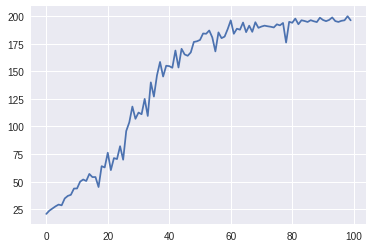

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(avg_rewards)
